Copyright (C) 2024 Pablo Castells y Alejandro Bellogín

El código que contiene este notebook se ha implementado para la realización de las prácticas de la asignatura "Búsqueda y minería de información" de 4º del Grado en Ingeniería Informática, impartido en la Escuela Politécnica Superior de la Universidad Autónoma de Madrid. El fin del mismo, así como su uso, se ciñe a las actividades docentes de dicha asignatura.

### **Búsqueda y Minería de Información 2023-24**
### Universidad Autónoma de Madrid, Escuela Politécnica Superior
### Grado en Ingeniería Informática, 4º curso

# Sistemas de recomendación

Fechas:

* Comienzo: martes 2 / jueves 4 de abril.
* Entrega: lunes 6 de mayo, 23:59.

## Objetivos

Esta práctica tiene por objetivo la implementación y evaluación eficiente de sistemas de recomendación. En este bloque se desarrollarán:

* Estructuras para el manejo de datos de interacción entre usuarios e items (diremos "ratings" para simplificar).
* Algoritmos de recomendación basada en filtrado colaborativo.
* Métricas de evaluación de sistemas de recomendación.

## Material proporcionado

Se proporcionan software y datos para la realización de la práctica:

* Un esqueleto de clases y funciones donde el estudiante desarrollará sus implementaciones. 
  - De modo similar a las prácticas anteriores, se proporciona una celda de prueba al final de este notebook que deberá funcionar con las implementaciones del estudiante.
  - Junto a la celda de prueba en este mismo notebook, se muestra como referencia un ejemplo de salida generada con una implementación de los profesores.
* Los siguientes conjuntos de datos de ratings por usuarios a items:
  - Dos conjuntos de juguete para prueba y depuración: <ins>toy1.csv</ins> (se genera en Matrices.ipynb) y <ins>toy2.csv</ins> (proporcionado en el curso Moodle) con ratings ficticios.
  - Un conjunto de datos reales de ratings a películas: *ml-1m.zip* disponible en la Web de [MovieLens](https://grouplens.org/datasets/movielens/1m). De los archivos disponibles, se utilizará sólamente <ins>ratings.dat</ins>, añadiéndole una cabecera `u::i::r::t`.
  
Los esqueletos de código que se proporcionan aquí son a modo de guía: el estudiante puede modificarlo todo libremente, siempre que la celda de prueba funcione correctamente **sin cambios**.

## Calificación

El peso de esta práctica en la nota final de prácticas es del **40%**.

La calificación se basará en el **número** de ejercicios realizados y la **calidad** de los mismos. La puntuación que se indica en cada apartado es orientativa, en principio se aplicará tal cual se refleja pero podrá matizarse por criterios de buen sentido si se da el caso.

Para dar por válida la realización de un ejercicio, el código deberá funcionar (a la primera) integrado con las clases que se facilitan. El profesor comprobará este aspecto ejecutando la celda de prueba y otras adicionales.

La corrección de las implementaciones se observará por la **coherencia de los resultados** (por ejemplo, las métricas sobre los algoritmos de recomendación), y se valorará la eficiencia en tiempo de ejecución.

## Entrega

La entrega consistirá en un fichero tipo *notebook* donde se incluirán todas las **implementaciones** solicitadas en cada ejercicio, así como una explicación de cada uno a modo de **memoria**.

## Indicaciones

La realización de los ejercicios conducirá en muchos casos a la implementación de funciones y/o clases adicionales a las que se indican en el enunciado. Algunas vendrán dadas por su aparición en los propias celdas de prueba, y otras por conveniencia a criterio del estudiante.

Igual que en prácticas anteriores, no deberá editarse la celda de prueba. Esta celda deberá ejecutar sin errores a la primera con el código entregado por el estudiante (naturalmente con salvedad de los ejercicios que no se hayan implementado.

## Ejercicio 1: Estructuras de datos y recomendación simple (2pt)

#### 1.1 &nbsp; Estructuras de datos

Implementar las clases necesarias para manejar **datos de entrada y prueba** (ratings) para los algoritmos de recomendación. La funcionalidad se implementará en una clase Ratings, que permitirá leer los datos de un fichero de texto, así como un método que genere dos particiones aleatorias de entrenamiento y test, para evaluar y comparar la efectividad de diferentes algoritmos de recomendación.

In [1]:
import numpy as np
import pandas as pd
import copy

class Ratings:
    def __init__(self, file=None, sep=','):
        """
        Constructor method for this class. Reads a ratings matrix from file and
        loads it to memory.

        Args:
            file (str): path for the csv file where the matrix is stored.
            sep (str): separation between elements in the csv file.
        """
        ratings_df = pd.read_csv(file, sep=sep)
        self.m = ratings_df.pivot_table(index='u', columns='i', values='r', fill_value=0).to_numpy()
        
        # Conversion tables
        self.t_uidx_to_uid = np.sort(ratings_df.u.unique())
        self.t_iidx_to_iid = np.sort(ratings_df.i.unique())
        # Conversion dictionaries
        self.d_uid_to_uidx = { k:i for i,k in enumerate(self.t_uidx_to_uid)}
        self.d_iid_to_iidx = { k:j for j,k in enumerate(self.t_iidx_to_iid)}

    
    def matrix(self):
        """
        Returns the ratings matrix of this object.
        """
        return self.m
    
    def nusers(self):
        """
        Returns the number of users in the matrix.
        """
        return self.t_uidx_to_uid.shape[0]
    
    def nitems(self):
        """
        Returns the number of items in the matrix.
        """
        return self.t_iidx_to_iid.shape[0]
    
    # uidx can be an int or an array-like of ints.
    def uidx_to_uid(self, uidx):
        """
        Returns an explicit representation for an user id.

        Args:
            uidx (int): user id, an index for the ratings matrix.
        """
        return self.t_uidx_to_uid[uidx]
        
    # iidx can be an int or an array-like of ints.
    def iidx_to_iid(self, iidx):
        """
        Returns an explicit representation for an item id.
        
        Args:
            iidx (int): item id, an index for the ratings matrix.
        """
        return self.t_iidx_to_iid[iidx]
    
    def uid_to_uidx(self, uid):
        """
        Returns an implicit id for a user representation.

        Args:
            uid (Any): User representation.
        """
        return self.d_uid_to_uidx[uid]
        
    def iid_to_iidx(self, iid):
        """
        Returns an implicit id for an item representation.

        Args:
            iid (Any): Item representation.
        """
        return self.d_iid_to_iidx[iid]
        
    def iidx_rated_by(self, uidx):
        """
        Returns the indices of items rated by the user with the given id.

        Args:
            uidx (int): user id, an index for the ratings matrix.
        """
        return np.ndarray.nonzero(self.m[uidx])
        
    def uidx_who_rated(self, iidx):
        """
        Returns the indices of users that rated this item with the given index.
        
        Args:
            iidx (int): item id, an index for the ratings matrix.
        """
        return np.ndarray.nonzero(self.m[:, iidx])
        
    def random_split(self, ratio):
        """
        Randomly splits the ratings matrix between two submatrices.

        Args:
            ratio (float): probability of an item going in the first submatrix.

        Returns:
            Two submatrices with the split items.
        """
        c1 = copy.deepcopy(self)
        c2 = copy.deepcopy(self)

        mask = np.random.choice([1, 0], size=self.m.shape, p=[ratio,1-ratio])

        c1.m = c1.m * mask
        c2.m = c2.m * (1 - mask)
        
        return c1,c2

    #
    # The remaining functions are just for debugging purposes
    #

    def rating(self, uid, iid):
        """
        Returns the user rating for the specified item.

        Args:
            uid (Any): User representation.
            iid (Any): Item representation.
        """
        return self.m[self.d_uid_to_uidx[uid], self.d_idd_to_iidx[iid]]

    def items_rated_by(self, uid):
        """
        Returns the indices of items rated by the user.

        Args:
            uid (Any): User representation.
        """
        return self.iidx_rated_by(self.d_uid_to_uidx[uid])
        
    def users_who_rated(self, iid):
        """
        Returns the indices of users that rated this item.

        Args:
            iid (Any): Item representation.
        """
        return self.uidx_who_rated(self.d_iid_to_iidx[iid])
    
    def user_ratings(self, uid):
        """
        Returns an item:rating dictionary of items rated by the user.

        Args:
            uid (Any): User representation.
        """
        uidx = self.d_uid_to_uidx[uid]
        indices = self.iidx_rated_by(uidx)
        return {item:rating for item, rating in zip(self.t_iidx_to_iid[indices], self.m[uidx][indices])}

    def item_ratings(self, iid):
        """
        Returns the indices of users that rated this item.
        
        Args:
            iid (Any): Item representation.
        """
        iidx = self.d_iid_to_iidx[iid]
        indices = self.uidx_who_rated(self.d_iid_to_iidx[iid])
        return {item:rating for item, rating in zip(self.t_uidx_to_uid[indices], self.m[:,iidx][indices])}
    
    def nratings(self):
        """
        Returns the total number of ratings in the matrix.
        """
        return np.count_nonzero(self.m)
        
    # To inspect random data splits.
    def save(self, file):
        """
        Saves the ratings matrix in the given filename.
        """
        df = pd.DataFrame(columns=self.iids, index=self.uids, data=self.m).unstack().reset_index(name='r')
        df.columns = ['i', 'u', 'r']
        df = df[df.r>0][['u', 'i', 'r']].sort_values(by=['u', 'i'])
        df.to_csv(file, index=False)

# Just for pretty-printing numbers.
def fround(x, n=20):
    r = round(x)
    rn = round(x, n)
    return r if rn == r else rn

#### 1.2 &nbsp;  Recomendaciones: métodos simples no personalizados

La **salida** de un recomendador consistirá en un diccionario con un ránking por usuario. 

Implementar un primer **recomendador simple** por rating promedio en una clase `AverageRecommender`. El recomendador sólo recomendará items que tengan un mínimo número de ratings, que se indicará como parámetro en el constructor (con ello se mejora el acierto de la recomendación). Se proporciona una clase `MajorityRecommender` a modo de ejemplo en el que el estudiante podrá basarse, así como `RandomRecommender`, que se utiliza en ocasiones como referencia en experimentos.



**Importante**: recordar que no deben recomendarse los items que los usuarios ya hayan puntuado.

In [2]:
# Suggestion: compute the scores in each recommenders' constructor.

from itertools import islice

# Given a matrix, .
def top_positions_per_row(m, k):
    """
    Returns a matrix of positions of top k values per row.

    Args:
        m (np.ndarray): Ratings matrix.
        k (int): top positions to return per row.
    """

    if (type(m) != np.ndarray):
        n = m.toarray()
        np.argpartition(m.col, k)
    else:
        return np.argpartition(m, -k)[:, -k:]
        
def top_positions_per_row2(m, k):
    """
    Returns a matrix of positions of top k values per row.

    Args:
        m (np.ndarray): Ratings matrix.
        k (int): top positions to return per row.
    """
    return np.argpartition(m, -k)[:, -k:]
    
class Recommendation:
    def __init__(self, scores, n, training):
        # Remove previosuly rated items
        mask = training.matrix() == 0
        self.scores = scores * mask

        # Get the top n positions per row
        top_iidx = np.sort(top_positions_per_row(self.scores, n))
        self.ranked_iidx_m = np.take_along_axis(top_iidx, np.argsort(np.take_along_axis(-self.scores, top_iidx, axis=1)), axis=1)

        # Get the iids of the elements
        ranked_iids = training.iidx_to_iid(self.ranked_iidx_m)
        self.rank_scores = np.take_along_axis(self.scores, self.ranked_iidx_m, axis=1)

        # Recommendations!
        self._recommendation = {uid : [(iid, score) for iid, score in zip(ranked_iids[uidx], self.rank_scores[uidx]) if score > 0] 
        for uidx, uid in enumerate(training.t_uidx_to_uid)} 
        
    def ranked_iidx(self):
        return self.ranked_iidx_m

    def score_matrix(self):
        return self.scores
        
    def recommendation(self, uid):
        return self._recommendation[uid]
        
    # This function is for debuggind purposes.
    # Format the recommendation as a string for the first n users. Trim scores to 4 decimal digits.
    def display(self, n):
        r = ''
        for uid in islice(self._recommendation, n):
            r += f'    User {uid} -> <' 
            for iid, score in self.recommendation(uid): 
                r += f'{iid}:{str(fround(score, 4))} '
            r = (r[:-1] + '>\n') if len(self.recommendation(uid)) > 0 else r + 'empty>\n'
        return r[:-1]
        
class Recommender():
    def __init__(self, training):
        self.training = training

    def __repr__(self):
        return type(self).__name__

    def recommend(self, n):
        return Recommendation(self.scores, n, self.training)

class RandomRecommender(Recommender):
    def __init__(self, training):
        super().__init__(training)
        self.scores = np.random.random(training.matrix().shape)

class MajorityRecommender(Recommender):
    def __init__(self, training, threshold=0):
        super().__init__(training)
        # training.matrix() >= threshold creates a mask with 'True' on relevant ratings and 'False' anywhere
        # else. Thus 'pop' is an array with the counts of relevant ratings of each item (since axis=0 applies
        # this sum column-wise).
        pop = np.sum(training.matrix() >= threshold, axis=0)
        # This product by a vector of ones (of user-row length) creates a matrix where the pop vector gets
        # copied on all rows; the recommendation is not personalized and ranking is the same for all users 
        # -- except of course in the end different training items will be filtered out for different users.
        self.scores = np.outer(np.ones(training.nusers()), pop)

class AverageRecommender(Recommender):
    """
    Class definition for a non-personalized recommender based on 
    the average scores of relevant items. An item is considered
    relevant, for this particular case, when it contains a minimum
    number of ratings, regardless of their individual score.
    """
    def __init__(self, training, minr=0):
        """
        Constructor method for this class. Computes intermediate scores for
        an average-based reccomendation, without removing elements that were
        already rated by users.
        """
        super().__init__(training)

        # Create a mask for items that were rated at least minr times
        # Then mask the ratings matrix
        n_ratings = np.count_nonzero(training.matrix(), axis=0)
        mask = n_ratings >= minr
        mask_scores = (training.matrix() * mask)

        # Count the ratings, avoid division by 0 by setting at least 1 rating per item
        n_ratings *= mask
        n_ratings[n_ratings == 0] = 1

        # Compute the user scores as the average of all ratings
        self.scores = np.outer(np.ones(training.nusers()), np.sum(mask_scores, axis=0) / n_ratings)

### Ejercicio 1 &ndash; Explicación/documentación

**Ratings**  
El objetivo de esta clase es poder implementar las operaciones relevantes a realizar sobre una *matriz de ratings*. Sobre cada uno de los items pertenecientes a una colección, un usuario *u* puede colocar un rating $r(u, i)$; aunque no necesariamente deben poseer un valor. De esta forma, se tiene:

- uidx, uid: Identificadores de usuario, tanto (1) numéricos como (2) lógicos (no necesariamente numérico). 
- iidx, iid: Identificadores de item, tanto (1) numéricos como (2) lógicos (no necesariamente numérico).

Los identificadores numéricos representan, en conjunto, el valor $r(u,i)$ dentro de la matriz de ratings, de forma `ratings[uidx][iidx]`. Los identificadores lógicos, en cambio, son las representaciones reales de usuarios e items; que deben ser convertidas a un formato utilizable por la matriz de ratings. Por este motivo, se hace uso de arrays y diccionarios que garantizan esta conversión de forma bidireccional:

- t_nidx_to_nid: Array que transforma el tipo de id N de un entero a una representación lógica.
- t_nid_to_nidx: Diccionario que garantiza la conversión contraria.

Finalmente, y sin tener en cuenta los métodos de debug, otro punto de interés sobre esta clase recae en los *random splits*, que permitirán generar particiones aleatorias sobre la matriz para poder realizar entrenamiento y test de recomendaciones.

**Recomendaciones**  
Es necesario crear *recomendadores* que permitan, dada la información ya contenida en la matriz, predecir que items serían de interés para los usuarios. Para realzar esto, se habla de *recomendaciones* $\hat{r}(u, i)$, las cuales calculan estimaciones de rating para usuarios, en base a ciertos parámetros. Para poder saber la efectividad de un recomendador es necesario comparar datos generados con datos reales: por esta razón se utilizan particiones de *entrenamiento* y *test*.

Por ejemplo, un recomendador que implementamos es el *AverageRecommender*, el cual es un recomendador no personalizado: en este caso, las similitudes no se tienen en cuenta. Si un item tiene un promedio de ratings muy alto (siempre con un mínimo de recomendaciones), este será recomendado al usuario. De esta forma, todos los vectores de scores obtenidos para cada usuario serán exactamente iguales, y por tanto las recomendaciones también serán las mismas. En cuanto a la clase *Recommendation*, esta simplemente se encarga de acumular los scores calculados por los *recomendadores* y devolver los cutoff resultados más altos.  

## Ejercicio 2: Filtrado colaborativo kNN (3pt)

Implementar un algoritmo de filtrado colaborativo mediante vecinos próximos orientado a usuarios por *similitud coseno* (sin normalizar por la suma de similitudes). 

In [3]:
class CosineUserSimilarity:
    def __init__(self, training):
        # Compute the dot similarity (u * v) of all users
        # The diagonal is filled with u^2 values for every user
        dot_matrix = training.matrix()@(training.matrix().T)

        # Get a vector of user mods, set to 1 when no ratings are given
        mods = np.sqrt(np.diag(dot_matrix))
        mods[mods==0] = 1

        # Create a similarity cosine matrix between users, and set our
        # own similarity to 0
        self.sim = ((dot_matrix / mods).T / mods).T
        np.fill_diagonal(self.sim, 0)

    def sim_matrix(self):
        return self.sim
        

class UserKNNRecommender(Recommender):
    def __init__(self, training, sim, k):
        super().__init__(training)

        # Get the k closest neighbours
        knn = top_positions_per_row(sim.sim_matrix(), k)

        # Create a mask where k neighbours = 1, else 0
        mask = np.zeros_like(sim.sim_matrix())
        mask[np.arange(mask.shape[0]), knn.T] = 1

        # Mask sim matrix
        knn_sim = sim.sim_matrix() * mask

        # Compute the scores
        self.scores = knn_sim@training.matrix()

### Ejercicio 2 &ndash; Explicación/documentación

En este caso, para realizar las estimaciones de ratings, se plantea un método basado en similitud: un usuario será recomendado items a los cuales otros k usuarios similares a el hayan dado un rating alto. Para calcular esta similitud, se realizará el **coseno** entre dos usuarios desde la matriz de ratings de entrenamiento; por supuesto, no es idea recomendar a un usuario elementos a los cuales ya haya hecho ratings (la similitud de un usuario con el mismo siempre es 1), por lo que todas las diagonales de la matriz deberían ser ignoradas a la hora de calcular los scores.

Con la similitud definida, el filtrado colaborativo k-nearest-neighbors (KNN) obtiene los scores de los K usuarios con similitud más alta al actual y computa la recomendación bajo un producto escalar de la matriz:

\begin{align}
\hat{r}(u, i) = \sum_{v \in K}{sim(u,v) \times r(v,i)}
\end{align}

## Ejercicio 3: Filtrado colaborativo: factorización de matrices (2pt)

Implementar filtrado colaborativo mediante factorización de matrices.

In [4]:
from matplotlib import pyplot as plt
import matplotlib
import datetime, time

def plot(train_losses, test_values=[], test_metrics=[]):
    f = plt.figure()
    plt.plot(range(len(train_losses)), train_losses, color='blue', linewidth=.7, label='Training MSE')
    plt.xlabel('Epoch')
    plt.ylabel('Training error')
    ax = plt.gca().twinx()
    for m, m_name, color in zip(test_values, test_metrics, ['tab:red', 'darkgreen', 'darkorange', 'darkviolet']):
        ax.plot(range(len(m)), m, linewidth=.7, color=color, label=f'Test {m_name}')
        plt.ylabel('Test metric')
    f.legend(loc='center right', bbox_to_anchor=(0.85, 0.5))

def print_progress(rec, start, epoch, error, test_values, test_metrics):
    output = f'\rTraining MF --> Epochs: {epoch+1}  Training error: {error}  '
    if test_metrics: output += 'Test metrics: ' 
    for values, metric in zip(test_values, test_metrics): 
        val = metric.compute(rec.recommend(metric.cutoff))
        output += f'{metric} = {val}  '
        values.append(val)
    output += f' \033[94m[{datetime.timedelta(seconds=round(time.time() - start))}]\033[0m'
    print(output, end='              ')
        
class MF(Recommender):
    def __init__(self, training, dim=50, lrate=.001, nepochs=20, test_metrics=[]):
        super().__init__(training)
        self.scores = self.predict(*self.train(dim, lrate, nepochs, test_metrics))

        
    def predict(self, p, q):
        return (p @ q.T) #* self.mask
        
    def train(self, dim, lrate, nepochs, test_metrics):
        # u = 50, i = 10, k = 3
        p = abs(np.random.normal(scale=1/self.training.nusers(), size=(self.training.nusers(), dim))) # 50x3
        q = abs(np.random.normal(scale=1/self.training.nitems(), size=(self.training.nitems(), dim))) # 10x3
        
        ratings = self.training.matrix()
        
        train_errors, test_values = [], [[] for _ in test_metrics]
        start = time.time()
        for epoch in range(nepochs):
            self.scores = self.predict(p,q)
            err = ratings - self.scores # 50x3 @ 3x10 -> 50x10
            #p, q = p + lrate * (err @ q), q + lrate * (err.T @ p) # 50x10@10x3, 10x50@50x3
            p = p + lrate * (err @ q)
            q = q + lrate * (err.T @ p)
            
            e = (err**2).mean()
            train_errors.append(e)
            print_progress(self, start, epoch, e, test_values, test_metrics)
        print()
        # Don't plot for small datasets.
        if self.training.nratings() > 1000 : plot(train_errors, test_values, test_metrics)
        return p, q

### Ejercicio 3 &ndash; Explicación/documentación

Otra forma de poder realizar recomendaciones a los usuarios se centra sobre los facotres latentes $f \in F$, esto es, representar tanto a los usuarios como items según un vector de características $u^F$ y $i^F$, espacios pequeños que puedan representar sus gustos y sean más efectivos de calcular que KNN. De esta forma, la recomendación $\hat{r}(u,i)$ pasa a ser simplemente $u \times i$. Lo que restaría hacer es obtener estas representaciones de usuarios e items, es decir, crear los parámetros del modelo.

Esto lo haremos con entrenamiento basado en el descenso por gradiente, con la idea de minimizar el error cuadrático $({r(u,i) - u \times i})^2$ para cada usuario e item. Para hacerlo sobre todas las combinaciones usuario-item a la vez, podemos pasar de vectores $u^k$, $i^k$ directamente a matrices $p^{|U| \times k}$, $q^{|I| \times k}$, de manera que el algoritmo se vería como el siguiente:
```
for n from 0 to nepochs
    e = r(u,i) - p * q.T
    p, q = p + α (e * q), q + α (e.T * p)
```
Es importante notar que, en python, existe una sutíl diferencia en los resultados si se calculan p y q en la misma sentencia o por separado. En la solución A (presentado en este pseudocódigo), utiliza los valores de $p$ y $q$ de la época de entrenamiento actual en ambas asignaciones: $p^i$, $q^i$, $i \in$ $n_{epochs}$. En la solución B (dentro del ejercicio), el cálculo de $q$ se realiza utilizando al $p$ de la siguiente época (que fue asignado en la instrucción anterior): $p^{i+1}$. Esto puede dar resultados diferentes con respecto a las ejecuciones de test provistas, por lo que si bien la solución A es "correcta", optamos por utilizar la solución B para cuadrar resultados.

## Ejercicio 4: Evaluación (2pt)

Se desarrollarán clases que permitan calcular métricas para evaluar y comparar el acierto de los recomendadores: se implementarán **precisión** y **recall**. 

Como resumen de este bloque, se incluirá una *tabla con los valores de las métricas* (dos columnas) más el tiempo de ejecución (una columna más) sobre todos los algoritmos implementados (filas), al menos para el conjunto de datos de <ins>MovieLens 1M</ins>. En el caso de ser capaces de procesar un conjunto de datos más grande, se documentará el tamaño en RAM de la matriz de ratings.

<!-- Opcionalmente, se podrán implementar otras métricas a elección del estudiante (nDCG, etc.), cuya prueba se incluirá en la función `student_test()` del ejercicio 4 ("ampliaciones"). -->

In [5]:
class Metric():
    def __init__(self, test, cutoff):
        self.test = test
        self.cutoff = cutoff

    def __repr__(self):
        return type(self).__name__ + ('@' + str(self.cutoff) if self.cutoff != np.inf else '')

class Precision(Metric):
    def __init__(self, test, cutoff=np.inf, threshold=1):
        super().__init__(test, cutoff)
        # This is the threshold of the score to be considered either relevant or not
        self.threshold = threshold

    def compute(self, recommendation):
        k_recommendations = recommendation.ranked_iidx()[:,0:self.cutoff]
        
        x = np.take_along_axis(recommendation.score_matrix(), k_recommendations, axis=1)
        y = np.take_along_axis(self.test.matrix(), k_recommendations, axis=1)
        
        relevant_m = (x >= 0) * (y >= self.threshold)

        return (np.sum(relevant_m, axis=1) / self.cutoff).mean()
        
class Recall(Metric):
    def __init__(self, test, cutoff=np.inf, threshold=1):
        super().__init__(test, cutoff)
        self.threshold = threshold
        self.individual_relevant = np.sum(test.matrix() >= threshold, axis=1)
        self.individual_relevant[self.individual_relevant == 0] = 1
        
    def compute(self, recommendation):
        k_recommendations = recommendation.ranked_iidx()[:,0:self.cutoff]
        
        x = np.take_along_axis(recommendation.score_matrix(), k_recommendations, axis=1)
        y = np.take_along_axis(self.test.matrix(), k_recommendations, axis=1)
        
        relevant_m = (x >= 0) * (y >= self.threshold)

        return (np.divide(np.sum(relevant_m, axis=1), self.individual_relevant)).mean()

### Ejercicio 4 &ndash; Explicación/documentación

Para poder evaluar los algoritmos de ranking implementados anteriormente, utilizamos dos medidas ya presentadas en los sistemas de information retrieval:
- Precision: El número de documentos relevantes devueltos, sobre el número de documentos *total devuelto*.
- Recall: El número de documentos relevantes devueltos, sobre el número de documentos *relevantes totales*.

Para los *sistemas de recomendación*, la 'relevancia' de un documento refiere a los propios ratings de usuarios sobre items: Aquellos items cuyo rating de usuario $r(u,i)$ sea superior a cierto threshold serán considerados relevantes, y el resto no.

Por tanto, para ambas métricas, se hace uso de dos matrices *x*, *y*, que actúan como representación de las dos condiciones a cumplir: el conjunto de scores de cada usuario (hasta cutoff elementos), y aquellos que cumplan el threshold esperado. Ambas métricas son obtenidas de realizar operaciones básicas sobre el resultado obtenido de multiplicar dichas matrices, que pasarán a contener valores binarios:

- Precision: media de unos por fila entre el cutoff. `(row.count(1) / cutoff).mean()`
- Recall: media de unos por fila entre total relevante por usuario. `(row.count(1) / self.nrelevant).mean()`

Para la siguiente tabla de métricas, el campo "tiempo de ejecución" también tendremos en cuenta el tiepo que se tarda en construir las matrices de recomendaciones, puesto que sino todos los tiempos serán 00:00.

Tabla de resumen **MovieLens 1M**. 

||Precision@K|Recall@K|Tiempo de ejecución
|-|:-:|:-:|:-:
|**RandomRecommender**|0.005397350993377485|0.002749305863731276|0:00:01
|**MayorityRecommender**|0.15114238410596026|0.09141827174714759|0:00:00
|**AverageRecommender**|0.009701986754966889|0.006141799629131731|0:00:00
|**UserKNNRecommender**|0.23014900662251653|0.17895309718471897|0:00:15
|**MFRecommender**|0.27764900662251657|0.1927300021391895|0:02:35
|**ItemKNNRecommender**|0.23639072847682122|0.1927300021391895|0:00:20
|**NormalizedKNNRecommender**|0.27764900662251657|0.1927300021391895|0:07:50

## Ejercicio 5: Ampliaciones (2pt)

Elegir uno de los siguientes ejercicios:

* Implementar dos variantes de kNN a elección del estudiante, por ejemplo: kNN normalizado, vecinos próximos orientado a item, similitud de Pearson, kNN centrado en la media. Indicación: para kNN normalizado el algoritmo exigirá un mínimo de ratings de vecinos para aceptar recomendar un item (con ello se mejora el acierto de la recomendación, de forma similar a la recomendación por rating promedio).
* Crear una implementación de las estructuras de ratings con matrices dispersas, de forma que sea posible generar recomendaciones sobre conjuntos de datos más grandes, tales como [MovieLens 10M](https://grouplens.org/datasets/movielens/10m) y [MovieLens 25M](https://grouplens.org/datasets/movielens/25m).

Para probar las implementaciones deberá completarse la función `student_test()` para ilustrar la ejecución de las variantes adicionales, y se incluirán las filas que correspondan en la tabla del apartado anterior.

In [6]:
# Código aquí: clases, funciones...
class CosineItemSimilarity:
    def __init__(self, training):
        # Compute the dot similarity (i * j) of all users
        # The diagonal is filled with i^2 values for every item
        dot_matrix = training.matrix().T@(training.matrix())

        # Get a vector of item mods, set to 1 when no ratings are given
        mods = np.sqrt(np.diag(dot_matrix))
        mods[mods==0] = 1

        # Create a similarity cosine matrix between items, and set our
        # own similarity to 0
        self.sim = ((dot_matrix / mods).T / mods).T
        np.fill_diagonal(self.sim, 0)

    def sim_matrix(self):
        return self.sim

class ItemKNNRecommender(Recommender):
    def __init__(self, training, sim, k):
        super().__init__(training)

        # Get the k closest neighbours
        knn = top_positions_per_row(sim.sim_matrix(), k)

        # Create a mask where k neighbours = 1, else 0
        mask = np.zeros_like(sim.sim_matrix())
        mask[np.arange(mask.shape[0]), knn.T] = 1

        # Mask sim matrix
        knn_sim = sim.sim_matrix() * mask
        
        # Compute the scores
        self.scores = (knn_sim @ training.matrix().T).T
        
class NormalizedKNNRecommender(Recommender):
    def __init__(self, training, sim, k, minr=0):
        super().__init__(training)

        # Get the k closest neighbours
        knn = top_positions_per_row(sim.sim_matrix(), k)

        # Create a mask where k neighbours = 1, else 0
        mask = np.zeros_like(sim.sim_matrix())
        mask[np.arange(mask.shape[0]), knn.T] = 1

        # Mask sim matrix
        knn_sim = sim.sim_matrix() * mask

        # Create a mask where a score is True if at least 
        # minr neighbours rated the item, else False
        mask = ((knn_sim > 0)*1)@((training.matrix()>0)*1) >= minr

        # Compute the scores
        norm = knn_sim@(training.matrix()>0)
        norm[norm==0] = 1
        
        self.scores = ((knn_sim@training.matrix()) / norm) * mask

def student_test(ratings_file="data/toy1.csv", sep=",", k=4, topn=4, cutoff=4, threshold=1, minr=0):
    np.random.seed(0)
    start = time.time()
    ratings = Ratings(ratings_file, sep)
    train, test = ratings.random_split(0.8)
    metrics = [Precision(test, cutoff=cutoff, threshold=threshold), Recall(test, cutoff=cutoff, threshold=threshold)]
    
    print('\n=========================\nExtra testing checking')
    ratings = Ratings(ratings_file, sep)
    
    print('-------------------------')
    print('Creating item cosine similarity')
    sim = CosineItemSimilarity(train)
    start = timer(start)
    print('Creating kNN recommender')
    knn = ItemKNNRecommender(train, sim, k)
    start = timer(start)
    run_recommender(knn, metrics, topn)
    timer(start)

    print('-------------------------')
    print('Creating user cosine similarity')
    sim = CosineUserSimilarity(train)
    start = timer(start)
    print('Creating kNN average recommender')
    knn = NormalizedKNNRecommender(train, sim, k, minr)
    start = timer(start)
    run_recommender(knn, metrics, topn)
    timer(start)


### Ejercicio 5 &ndash; Explicación/documentación

Existen varios métodos de knn alternativos al basado en el usuario. En este caso, optamos por implementar dos: KNN basado en *items* y KNN *normalizado*.

Para el primero de los casos, el **KNN basado en items**, se debe transponer la forma de pensar en el problema. En lugar de hacer recomendaciones de usuario basados en ratings de otros usuarios similares, se ven los propios items a los que el usuario ya haya valorado; y se calcula la *similitud entre items*. En este caso, la similitud también viene dada en forma de coseno con respecto a los 'vectores item': los ratings de usuario sobre cada item, es decir, las *columnas*.

En términos de código, lo único que cambia a la hora de realizar la clase `CosineUserSimilarity` es el orden de multiplicación de matrices: se multiplica la matriz de entrenamiento transpuesta con la original, en lugar de *viceversa*. Ya que la matriz de similitud resultante será de orden $|I|$ en lugar de orden $|U|$, es necesario transponerla nuevamente para operar con la matriz de entrenamiento $|U| \times |I|$, y luego transponer el resultado nuevamente para dar un score con las dimensiones originales.

El segundo de los casos, el **KNN normalizado**, es una extensión del algoritmo original de KNN basado en usuarios; lo único que se debe hacer es dividir por la suma de las similitudes para obtener un ranking válido (en nuestro caso, entre 1 y 5). Eso implica que no se necesita cambiar la clase original que calcula similitudes, sino que solo el modo de computar scores preliminares. La forma de calcular estos factores de normalización es realizar otro producto de matrices, tratando los ratings como valores booleanos ($\forall$ $i,j;$ $\exists$ $r(i,j) > 0$?); de esta forma, se elige que similitudes usar y cuales no.

Luego, para poder dar mayor fiabilidad a este tipo de ranking, es necesario que se tenga un número de rankings mínimo por parte de los vecinos. Es decir, si solo existe un vecino dentro de los k más proximos que haya dado rating de 5 a un item, es muy probable que este sea la primera recomendación. Para garantizar dicha condición se usa una segunda máscara:

- `((knn_sim > 0)*1)@((training.matrix()>0)*1) >= minr`

Esta, a diferencia de un `np.count_nonzeros()` por columnas, cubre un caso particular que la anterior no. A la hora de contar ratings, la máscara original (i.e., la del Average Recommender) también tiene en cuenta el rating propio para el mínimo de ratings; esto puede dar un caso donde el número de ratings vecinos es $minr - 1$, y que con el rating de usuario dicha métrica se de como válida (en el caso límite de minr=1, implica también una división por cero). Las transformaciones aplicadas en la matriz de similitud y entrenamiento computan, en cada valor resultante, cuáles de los k-vecinos han valorado el item.

## Celda de prueba

Descarga los ficheros de datos y coloca sus contenidos en una carpeta **data** en el mismo directorio que este *notebook*.

Testing toy 1 dataset
Reading the data at 19:24:20...
Ratings matrix takes 0.0 MB in RAM
--> elapsed time: 0:00:00 <--
-------------------------
Testing the ratings data structures
11 ratings by 4 users on 5 items
Ratings of user v: {'b': 4.0, 'c': 5.0, 'd': 3.0}
Ratings of item b: {'v': 4.0, 'x': 2.0, 'y': 4.0}
-------------------------
Testing RandomRecommender (top 4)
Four example recommendations:
    User v -> <a:0.9786 e:0.1183>
    User x -> <c:0.9447 d:0.5218>
    User y -> <d:0.5684 e:0.0188>
    User z -> <e:0.6818 a:0.6176 c:0.6169 b:0.6121>
Precision@4 = 0.0625
Recall@4 = 0.25
--> elapsed time: 0:00:00 <--
-------------------------
Testing MajorityRecommender (top 4)
Four example recommendations:
    User v -> <a:1 e:1>
    User x -> <c:2 d:1>
    User y -> <d:1 e:1>
    User z -> <b:2 c:2 a:1 e:1>
Precision@4 = 0.0625
Recall@4 = 0.25
--> elapsed time: 0:00:00 <--
-------------------------
Testing AverageRecommender (top 4)
Four example recommendations:
    User v -> <a:3>
 

/tmp/ipykernel_6847/1864745669.py:15: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings_df = pd.read_csv(file, sep=sep)


Ratings matrix takes 170.8 MB in RAM
--> elapsed time: 0:00:05 <--
-------------------------
Testing the ratings data structures
1,000,209 ratings by 6,040 users on 3,706 items
Ratings of user 200: {8: 3.0, 170: 5.0, 940: 4.0, 1059: 5.0, 1127: 4.0, 1441: 4.0, 1605: 1.0, 1911: 2.0, 2041: 5.0, 2355: 3.0, 2555: 2.0, 2572: 5.0, 2599: 3.0, 2605: 2.0, 2683: 3.0, 2694: 5.0, 2699: 4.0, 2706: 2.0, 2759: 2.0, 2770: 2.0, 2779: 2.0, 2827: 3.0, 2997: 4.0, 3051: 5.0, 3408: 5.0, 3751: 4.0}
Ratings of item 1000: {474: 5.0, 1733: 2.0, 2820: 3.0, 3032: 4.0, 3193: 2.0, 3197: 3.0, 3224: 4.0, 3391: 3.0, 3507: 4.0, 3526: 3.0, 3644: 5.0, 3829: 4.0, 3868: 4.0, 3942: 1.0, 4088: 3.0, 4139: 4.0, 4732: 3.0, 5426: 2.0, 5682: 1.0, 5916: 1.0}
-------------------------
Testing RandomRecommender (top 10)
Four example recommendations:
    User 1 -> <3627:0.9996 3007:0.9991 1103:0.999 2399:0.9989 69:0.9988 900:0.9987 2750:0.9987 154:0.9986 2478:0.9985 1928:0.9983>
    User 2 -> <2417:1 187:0.9995 3239:0.9994 1850:0.9986

/tmp/ipykernel_6847/1864745669.py:15: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings_df = pd.read_csv(file, sep=sep)



Extra testing checking


/tmp/ipykernel_6847/1864745669.py:15: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings_df = pd.read_csv(file, sep=sep)


-------------------------
Creating item cosine similarity
--> elapsed time: 0:00:14 <--
Creating kNN recommender
--> elapsed time: 0:00:06 <--
Testing ItemKNNRecommender (top 10)
Four example recommendations:
    User 1 -> <364:13.6401 588:13.1319 2087:11.7567 1688:10.8046 2078:10.5542 2394:9.8696 593:9.1441 2716:8.9833 2080:8.789 1947:8.5721>
    User 2 -> <1580:18.6165 110:16.529 377:15.9019 733:15.4245 260:14.7194 349:13.2815 1918:13.1735 1573:12.7744 3793:12.295 1608:11.9151>
    User 3 -> <1291:11.7745 260:11.3979 2987:11.1844 2791:11.0182 2804:10.79 1:10.4432 2918:10.3757 1288:10.0501 1080:10.0132 1234:9.1186>
    User 4 -> <1291:12.7522 1270:12.2498 589:10.3454 2571:10.3071 1197:9.7684 858:9.6686 1200:9.3625 2194:9.2543 1127:8.9986 541:8.0335>
Precision@10 = 0.23639072847682122
Recall@10 = 0.16278150258092822
--> elapsed time: 0:00:00 <--
-------------------------
Creating user cosine similarity
--> elapsed time: 0:00:05 <--
Creating kNN average recommender
--> elapsed time: 0:0

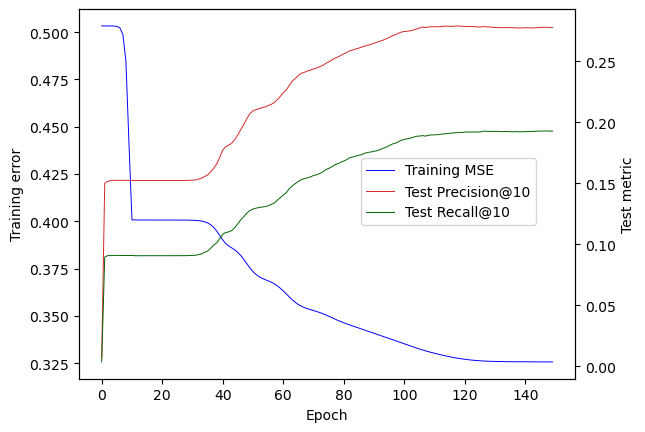

In [7]:
import datetime, time

# Test data structures and algorithms on a dataset.
def test(ratings_file, example_user, example_item, k, minr, dim, topn=np.inf, cutoff=np.inf, threshold=1, sep=','):
    print(colored(f'Reading the data at ' + time.strftime('%X...'), 'blue'))
    start = time.time()
    ratings = Ratings(ratings_file, sep)
    print(f'Ratings matrix takes {round(10 * ratings.matrix().nbytes / 1024 / 1024) / 10:,} MB in RAM')
    timer(start)

    # Test Ratings class on the dataset.
    test_data(ratings, example_user, example_item)
    
    # Produce a rating split and test a set of recommenders. 
    train, test = ratings.random_split(0.8)
    metrics = [Precision(test, cutoff=cutoff, threshold=threshold), Recall(test, cutoff=cutoff, threshold=threshold)]
    run_recommenders(train, metrics, k, minr, dim, topn)

# Test the rating data handling code (Ratings class).
def test_data(ratings, example_user, example_item):
    print('-------------------------\nTesting the ratings data structures')
    print(f'{ratings.nratings():,} ratings by {ratings.nusers():,} users on {ratings.nitems():,} items')
    print(f'Ratings of user {example_user}: {ratings.user_ratings(example_user)}')
    print(f'Ratings of item {example_item}: {ratings.item_ratings(example_item)}')

# Run some recommenders on the some rating data as input - no evaluation.
def run_recommenders(train, metrics, k, minr, dim, topn):
    print('-------------------------')
    start = time.time()
    run_recommender(RandomRecommender(train), metrics, topn)
    start = timer(start)
    
    print('-------------------------')
    run_recommender(MajorityRecommender(train, threshold=4), metrics, topn)
    start = timer(start)
    
    print('-------------------------')
    run_recommender(AverageRecommender(train, minr), metrics, topn)
    start = timer(start)
    
    print('-------------------------')
    print('Creating user cosine similarity')
    sim = CosineUserSimilarity(train)
    start = timer(start)
    print('Creating kNN recommender')
    knn = UserKNNRecommender(train, sim, k)
    start = timer(start)
    run_recommender(knn, metrics, topn)
    timer(start)

        
    print('-------------------------')
    start = time.time()
    print('Creating MF recommender')
    mf = MF(train, dim=dim, lrate=.0005, nepochs=150, test_metrics=metrics)
    start = timer(start)
    run_recommender(mf, metrics, topn)
    timer(start)

# Run a recommender and evaluate a list of metrics on its output.
def run_recommender(recommender, metrics, topn):
    print(f'Testing {recommender} (top {topn})')
    recommendation = recommender.recommend(topn)
    print('Four example recommendations:\n' + recommendation.display(4))
    for metric in metrics:
        print(metric, '=', metric.compute(recommendation))

from termcolor import colored
def timer(start):
    print(colored(f'--> elapsed time: {datetime.timedelta(seconds=round(time.time() - start))} <--', 'blue'))
    return time.time()
    
np.random.seed(0)
print('=========================\nTesting toy 1 dataset')
test('data/toy1.csv', example_user='v', example_item='b', k=4, minr=2, dim=5, topn=4, cutoff=4)
print('=========================\nTesting toy 2 dataset')
test('data/toy2.csv', example_user=1, example_item=2, k=4, minr=2, dim=5, topn=4, cutoff=4)
print('=========================\nTesting MovieLens \'1 million\' dataset')
test('data/ratings-1m.dat', example_user=200, example_item=1000, k=10, minr=3, dim=20, topn=10, cutoff=10, threshold=4, sep='::')
print('=========================\nDone.')

# Additional testing?
student_test('data/ratings-1m.dat', sep='::', k=10, topn=10, threshold=4, cutoff=10, minr=5)

### Salida obtenida por el estudiante

*(por hacer)*